In [1]:
import pandas
from pandas import DataFrame
import numpy
import matplotlib.pyplot as plt

Gọi Dữ liệu
--- 

In [3]:
#%run GETAPI.ipynb  #for calling data

Xử lý dữ liệu đọc thêm tại file [Data exploration](Q_Data_Exploration.ipynb)

Đọc dữ liệu
---

In [2]:
symbols = pandas.read_csv('Data/symbols.csv')
data = pandas.read_csv('Data/data.csv')
f_data = pandas.read_csv('Data/token_price.csv')

try:
    symbols = symbols.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    data = data.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    f_data = f_data.drop(['Unnamed: 0'], axis=1)
except:
    pass
base_coin = ['BUSD','USDT'] # đồng tiền ổn định giá

## Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Theo như một số câu hỏi trước thì có rất ít loại đồng có ảnh hưởng đến nhau, nên trong model này ta chỉ huấn luyện trên 1 đồng để nhận xet thử

In [5]:
model_set = data[data.Symbol == 'ETHBTC'].sort_values('Kline open time')[['Open price','High price','Low price','Close price']]

model_set = StandardScaler().fit_transform(model_set)

In [6]:
train_X, train_y = model_set, model_set[5:]
train_X.shape,train_y.shape

((865, 4), (860, 4))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(
    units = 128,
    input_shape =(5,4)
))
model.add(layers.Dense(units = 4))
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 68,612
Trainable params: 68,612
Non-trainable params: 0
_________________________________________________________________


In [8]:
full_n = train_y.shape[0]
n  =  int(train_y.shape[0]*0.7)

In [9]:
ds = keras.preprocessing.timeseries_dataset_from_array(train_X[:n],train_y[:n],sequence_length=5,batch_size=1) #train
d2 = keras.preprocessing.timeseries_dataset_from_array(train_X[n:],train_y[n:],sequence_length=5,batch_size=1) #test

In [10]:
test_x = numpy.array([i[0] for i in d2])
test_x.resize(( full_n - n, 5, 4))

In [11]:
model.fit(ds)
y_pred = model.predict(test_x)
y_pred.shape

9/9 [==============================] - 1s 4ms/step


(258, 4)

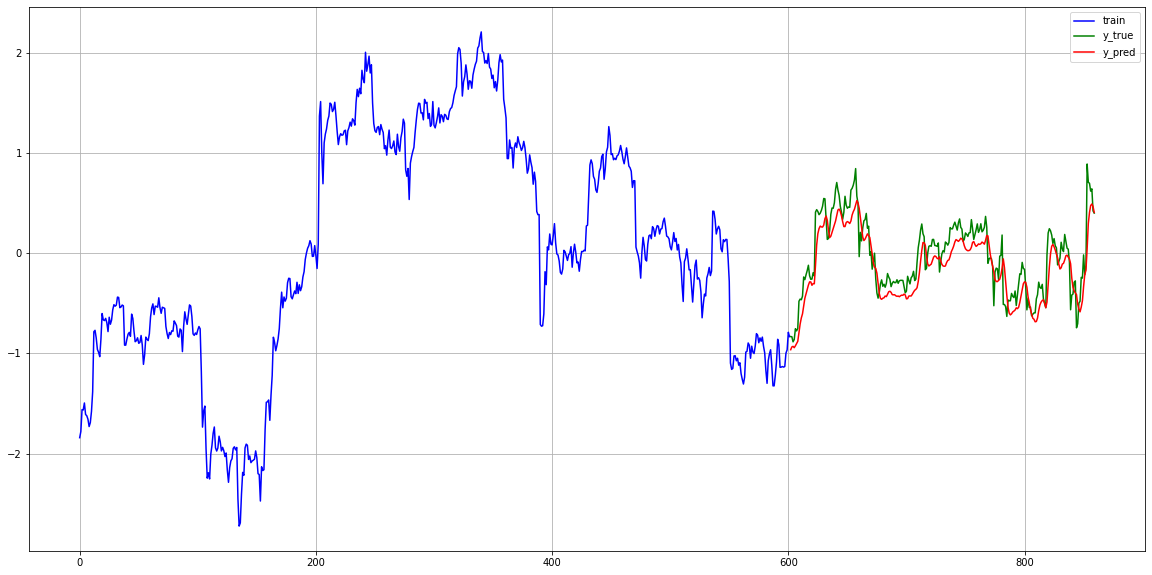

In [12]:
k = 2
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n,k],'b',label = 'train')
plt.plot(range(n,full_n),np.array(train_y)[n:,k],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:,k],'r',label = 'y_pred')
plt.legend()

In [13]:
[sklearn.metrics.r2_score( np.array(train_y)[n:,i],y_pred[:,i]) for i in range(4)]

[0.7924152691699283,
 0.7049013098446117,
 0.7193705014228686,
 0.6558435684135733]

---

In [14]:
from sklearn.linear_model import LinearRegression


In [15]:
linear_model = LinearRegression()
linear_model.fit( [ np.array(i[0]).flatten() for i in ds], [ np.array(i[1]).flatten() for i in ds] )

LinearRegression()

In [16]:
y_pred  = linear_model.predict( [ np.array(i[0]).flatten() for i in d2])
y_true = np.array([np.array(i[1]).flatten() for i in d2])

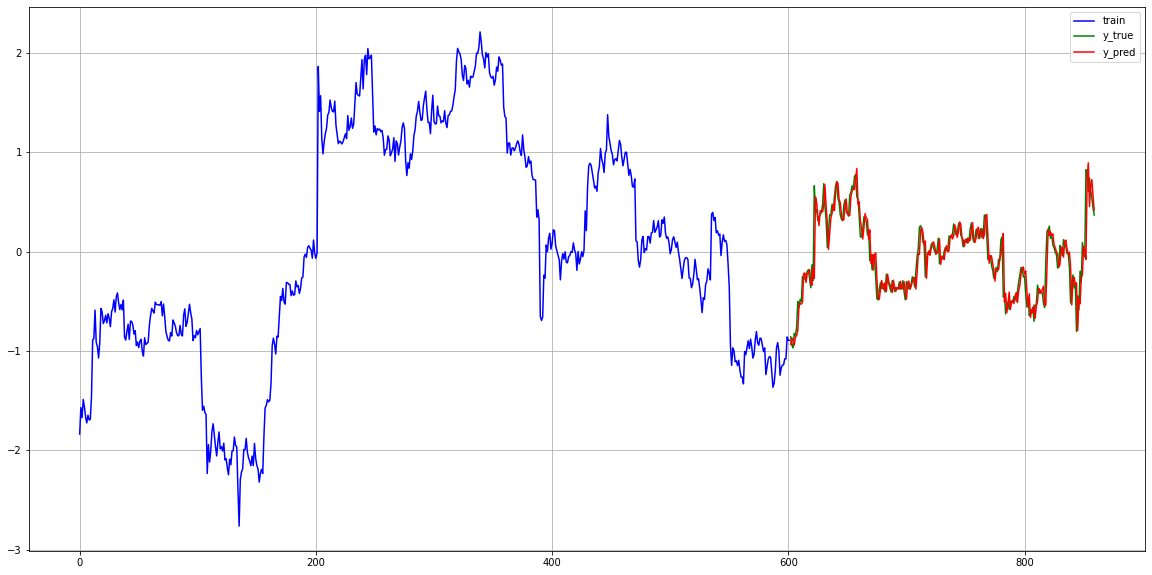

In [17]:
k = 3
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n,k],'b',label = 'train')
plt.plot(range(n,full_n),(y_true)[:,k],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:,k],'r',label = 'y_pred')
plt.legend()

In [18]:
[sklearn.metrics.r2_score( np.array(y_true)[:,i],y_pred[:,i]) for i in range(4)]

[0.9999436927999247, 0.8741147075253277, 0.908063666323902, 0.8282259142106378]

In [89]:
def r2_score_linear(symbol:str,plot = True,k=3,scaler = StandardScaler):
    set = data[data.Symbol == symbol].sort_values('Kline open time')[['Open price','High price','Low price','Close price']]
    if scaler != None:
        set = scaler().fit_transform(set)

    X, y = set, set[5:]

    _full_n = y.shape[0]
    _n  = int(y.shape[0]*0.7)

    d_s1 = keras.preprocessing.timeseries_dataset_from_array(X[:_n],y[:_n],sequence_length=5,batch_size=1) #train
    d_s2 = keras.preprocessing.timeseries_dataset_from_array(X[_n:],y[_n:],sequence_length=5,batch_size=1) #test

    linear_ = LinearRegression()
    linear_.fit( [ np.array(i[0]).flatten() for i in d_s1], [ np.array(i[1]).flatten() for i in d_s1] )
    _pred  = linear_.predict( [ np.array(i[0]).flatten() for i in d_s2])
    _true = np.array([np.array(i[1]).flatten() for i in d_s2])

    if plot:
        plt.figure(figsize=(20, 10))
        plt.grid(which='major', axis='both', zorder=-1.0)
        plt.plot( np.array(y)[:_n,k],'b',label = 'train')
        plt.plot(range(_n,_full_n),(_true)[:,k],'g',label = 'y_true')
        plt.plot(range(_n,_full_n), _pred[:,k],'r',label = 'y_pred')
        plt.legend()

    print( np.mean(_pred - _true ,axis = 0) )
    return np.array([sklearn.metrics.r2_score( _true[:,i],_pred[:,i]) for i in range(4)])

[-0.0001566  -0.0085964  -0.01872118 -0.02213848]


array([0.99998555, 0.95153192, 0.98227653, 0.94915843])

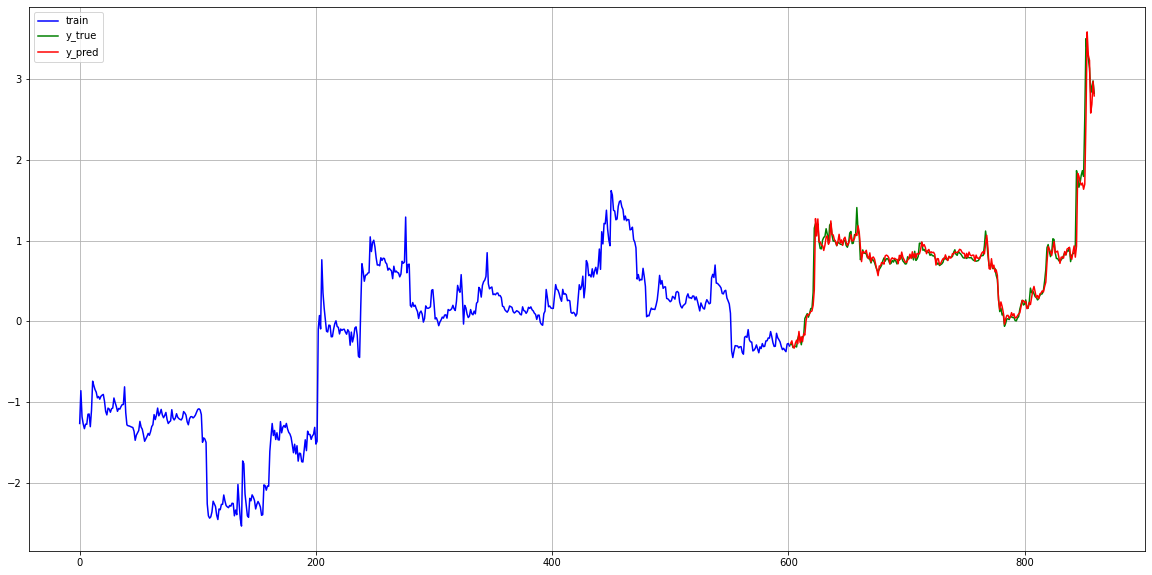

In [90]:
r2_score_linear('BTCUSDT',k=1)

Kết qua mô hình dự đoán với chỉ số khá cao, tuy nhiên việc áp dụng thực tế thì không hẳn là được, do dự đoán này sẽ phải dựa vào 5 mốc tgian trước đó, không phải hoàn toàn là sinh ra từ mô hình, nên việc giá có thể lên đỉnh, hoặc xuống đáy trong thời gian sau thì không được chắc chắn